In [17]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

from skopt import BayesSearchCV

from skopt.space import Real, Categorical, Integer

import pickle


In [18]:
# %pip install "numpy<1.24"
# import numpy as np
# np.__version__

In [23]:
data_file = "/Users/nuoaleon/Desktop/CISBAT/UE_samples/us_Adiabatic_WaterChiller.xlsx"
model_name = "xgb_" + data_file.split("/")[-1].replace("xlsx", "pkl")

df = pd.read_excel(data_file)
df.head()

,T_oa,RH_oa,P_atm,UPS_e,PD_lr,L_percentage,delta_T_air,Fan_Pressure_CRAC,Fan_e_CRAC,Pump_Pressure_HD,...,LGRatio,T_up,T_lw,dp_up,dp_lw,RH_up,RH_lw,pcop,PUE,WUE
0,-14.824219,25.097656,110527.368164,0.988066,0.0229,0.028271,13.845313,936.425781,0.713379,758105.46875,...,2.85332,27.321777,21.218262,26.380371,-8.56084,0.752607,0.106855,-0.063281,1.140107,0.00000
1,42.949219,25.097656,110527.368164,0.988066,0.0229,0.028271,13.845313,936.425781,0.713379,758105.46875,...,2.85332,27.321777,21.218262,26.380371,-8.56084,0.752607,0.106855,-0.063281,1.414555,2.48057
2,-14.824219,38.378906,110527.368164,0.988066,0.0229,0.028271,13.845313,936.425781,0.713379,758105.46875,...,2.85332,27.321777,21.218262,26.380371,-8.56084,0.752607,0.106855,-0.063281,1.140113,0.00000
3,-14.824219,25.097656,103600.854492,0.988066,0.0229,0.028271,13.845313,936.425781,0.713379,758105.46875,...,2.85332,27.321777,21.218262,26.380371,-8.56084,0.752607,0.106855,-0.063281,1.145212,0.00000
4,-14.824219,25.097656,110527.368164,0.911582,0.0229,0.028271,13.845313,936.425781,0.713379,758105.46875,...,2.85332,27.321777,21.218262,26.380371,-8.56084,0.752607,0.106855,-0.063281,1.231115,0.00000


In [20]:
X = df.drop(["PUE", "WUE"], axis=1)
y = df[["PUE", "WUE"]]

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size = 0.2, random_state=42)

In [21]:
#X.columns

In [5]:
pipeline = Pipeline( steps= [("scaler", StandardScaler()), ("estimator", MultiOutputRegressor(XGBRegressor()))])

# define search space
space = { 'estimator__estimator__n_estimators': (100,1000), ## Number of boosting rounds
          'estimator__estimator__learning_rate': Real(1e-6, 1e+0, prior='log-uniform'), ## Boosting learning rate (xgb’s “eta”)
          'estimator__estimator__reg_alpha': Real(1e-6, 1e+0, prior='log-uniform'), ## L1 regularization term on weights (xgb’s alpha).
          'estimator__estimator__reg_lambda': Real(1e-6, 1e+0, prior='log-uniform'), ##  L2 regularization term on weights (xgb’s lambda)
         }

model = BayesSearchCV(pipeline, search_spaces = space, n_iter=20, cv=5)


In [ ]:
result = model.fit(train_X,train_Y)

In [ ]:
y_pred = result.predict(test_X)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print(mean_squared_error(test_Y, y_pred, multioutput='raw_values'))
print(r2_score(test_Y, y_pred, multioutput='raw_values'))

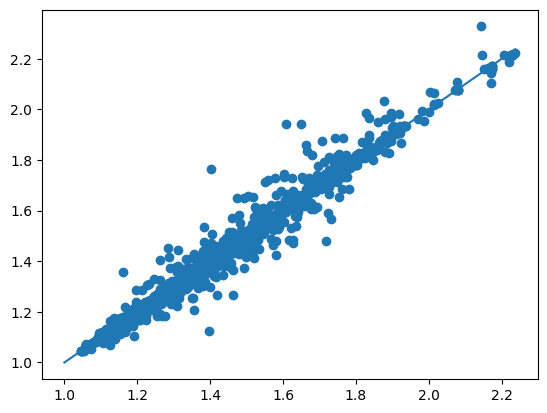

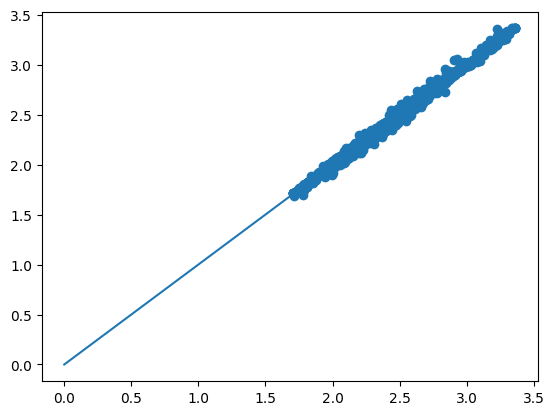

In [13]:
plt.scatter(y_pred[:,0], test_Y['PUE'])
plt.plot([1,max(y_pred[:,0])],[1,max(y_pred[:,0])])
plt.show()

plt.scatter(y_pred[:,1], test_Y['WUE'])
plt.plot([0,max(y_pred[:,1])],[0,max(y_pred[:,1])])
plt.show()


In [14]:
pickle.dump(result, open(model_name, 'wb'))
loaded_model = pickle.load(open(model_name, 'rb'))

In [15]:
print(r2_score(test_Y, result.predict(test_X), multioutput='raw_values'))

[0.98739438 0.99793488]


In [16]:
### Save Accurancy Score of Surrogate Model
import json

try:
    with open('surrogate_model_accurancy.json') as json_file:
        surrogate_model_accurancy = json.load(json_file)
except:
    surrogate_model_accurancy = {}

surrogate_model_accurancy[model_name.replace(".sav","")] = \
    {'mse': list(mean_squared_error(test_Y, y_pred, multioutput='raw_values')), 'r2': list(r2_score(test_Y, y_pred, multioutput='raw_values'))}


with open('surrogate_model_accurancy.json',"w") as outfile:
    json.dump(surrogate_model_accurancy , outfile)